# INF8245E - Assignment 1 
### Author : Guillaume Jones
### Date : 2021-10-04

## 1. Sampling

In [6]:
%%capture
%pip install --user numpy
%pip install --user matplotlib

In [7]:
import random

def sampleActivities(n):
    # Returns fractions for each activity after n samples
    activities_logger = {'Movies': 0.0, 'INF8245E': 0.0, 'Playing': 0.0, 'Studying': 0.0}
    for i in range(n):
        sample = random.uniform(0, 1)
        if sample < 0.2:
            activities_logger['Movies'] += 1/n
        elif sample < 0.6:
            activities_logger['INF8245E'] += 1/n
        elif sample < 0.7:
            activities_logger['Playing'] += 1/n
        else:
            activities_logger['Studying'] += 1/n

    return activities_logger


print('Fraction of 100 days in each activity:')
sample100 = sampleActivities(100)
for activity in sample100:
    print(f'\t{activity} : {sample100[activity]:.3f}')
    
print('Fraction of 1000 days in each activity:')
sample1000 = sampleActivities(1000)
for activity in sample1000:
    print(f'\t{activity} : {sample1000[activity]:.3f}')

Fraction of 100 days in each activity:
	Movies : 0.160
	INF8245E : 0.410
	Playing : 0.090
	Studying : 0.340
Fraction of 1000 days in each activity:
	Movies : 0.212
	INF8245E : 0.371
	Playing : 0.107
	Studying : 0.310


## 2. Model Selection

In [1047]:
import csv
import numpy as np

def importDataset(filename):
    # Opens a .csv dataset file as np array with 2 columns 
    with open(filename) as file:
        dataset_reader = csv.reader(file)
        dataset = np.transpose(np.array(list(dataset_reader)))
        dataset = dataset[:-1]
        return dataset.astype(float)

# Functions for polynomial model training

def matrixRmse(x, y, w):
    # Returns RMSE for matrices (polynomial functions)
    w_t = w.transpose()
    return np.sqrt((np.mean((y - np.dot(x, w)) ** 2)) / len(y))

def calculateW(x, y ,lda=0):
    # Calculates W coefficients, including regularization term if specified
    x_t = x.transpose()
    return np.dot(np.dot(np.linalg.inv(np.dot(x_t, x) + np.identity(len(x_t)) * lda), x_t), y)

def makePolynomialFromVector(x, degrees):
    # Transforms x into a matrix with polynomials
    new_x = x
    for degree in range(degrees + 1):
        # Adds new columns of x raised to 'degree' power
        new_x = np.c_[new_x, x**degree]

    # Removes first column as it now contains extra data
    return new_x[:, 1:]

def generatePolyMatricesFromDataset(dataset, degrees):
    # Helper function to generate matrices for polynomial training
    x_polynomial = makePolynomialFromVector(dataset[0], degrees)
    return dataset[0], dataset[1], x_polynomial


In [1048]:
# Training the model and displaying RMSE
degrees = 20

x_train, y_train, x_20_train = generatePolyMatricesFromDataset(importDataset("Datasets/Dataset_1_train.csv"), degrees)
x_valid, y_valid, x_20_valid = generatePolyMatricesFromDataset(importDataset("Datasets/Dataset_1_valid.csv"), degrees)

w = calculateW(x_20_train, y_train)

rmse_train = matrixRmse(x_20_train, y_train, w)
rmse_valid = matrixRmse(x_20_valid, y_valid, w)

print(f'Train RMSE : {rmse_train:.4f}')
print(f'Validation RMSE : {rmse_valid:.4f}')

Train RMSE : 0.3599
Validation RMSE : 5.3220


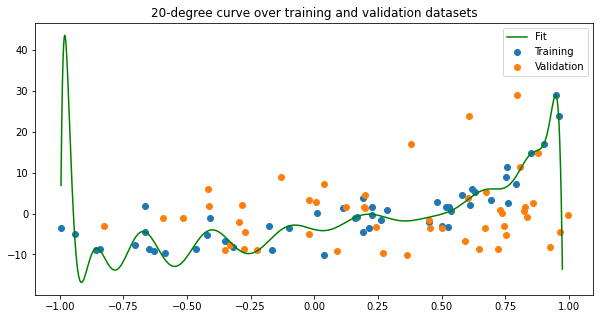

In [1049]:
# Visualizing the first model

import matplotlib.pyplot as plt

# Generate curve points
curve_x = np.linspace(-0.995, 0.975, 30000)
curve_x_20 = makePolynomialFromVector(curve_x, degrees)
curve_y = np.dot(curve_x_20, w)

# Display data and curve
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, label='Training')
plt.scatter(x_valid, y_train, label='Validation')
plt.plot(curve_x, curve_y, label='Fit', color='green')
plt.title('20-degree curve over training and validation datasets')
plt.legend()
plt.show()

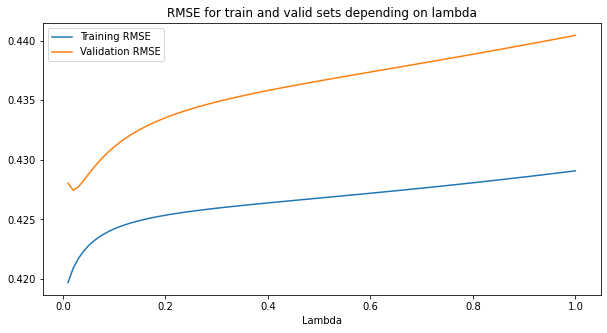

In [1050]:
# Training model with regularization term from 0 to 1

lambdas = np.arange(0.01, 1.01, 0.01)
best_lambda = None
best_model = None
train_rmses = []
valid_rmses = []
for lda in lambdas:
    w_reg = calculateW(x_20_train, y_train, lda)
    train_rmses.append(matrixRmse(x_20_train, y_train, w_reg))
    valid_rmse = matrixRmse(x_20_valid, y_valid, w_reg)
    valid_rmses.append(valid_rmse)
    if valid_rmse == min(valid_rmses):
        best_lambda = lda
        best_model = w_reg

plt.figure(figsize=(10, 5))
plt.plot(lambdas, train_rmses, label='Training RMSE')
plt.plot(lambdas, valid_rmses, label='Validation RMSE')
plt.title('RMSE for train and valid sets depending on lambda')
plt.xlabel('Lambda')
plt.legend()
plt.show()

In [1051]:
# Evaluating the best model on the test set
print(f'Best lambda: {best_lambda}')

test1 = importDataset("Datasets/Dataset_1_test.csv")
x_test, y_test, x_20_test = generatePolyMatricesFromDataset(test1, degrees)
test_rmse = matrixRmse(x_20_test, y_test, best_model)
print(f'Best model RMSE on test set: {test_rmse:.4f}')


Best lambda: 0.02
Best model RMSE on test set: 0.4633


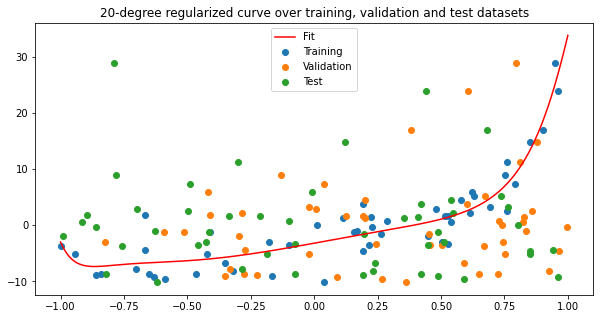

In [1052]:
# Visualizing the fit for the best model

# Generate fit curve points
curve_x = np.linspace(-1, 1, 30000)
curve_x_20 = makePolynomialFromVector(curve_x, degrees)
curve_y = np.dot(curve_x_20, best_model)

# Display data and curve
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, label='Training')
plt.scatter(x_valid, y_train, label='Validation')
plt.scatter(x_test, y_train, label='Test')
plt.plot(curve_x, curve_y, label='Fit', color='red')
plt.title('20-degree regularized curve over training, validation and test datasets')
plt.legend()
plt.show()

## 3. Gradient Descent for Regression

In [1053]:
# Functions for SGD training
def xyFromDataset(dataset):
    return dataset[0], dataset[1]

def linearRmse(x, y, w0, w1):
    # Returns RMSE for linear functions (w0 and w1 only)
    return np.sqrt((np.mean((y - (w1*x + w0)) ** 2)) / len(y))
    
def performLinearSGD(x_train, y_train, x_valid, y_valid, step, w0=0.0, w1=1.0, max_iter=10000):
    epochs_train_rmse = [linearRmse(x_train, y_train, w0, w1)]
    epochs_valid_rmse = [linearRmse(x_valid, y_valid, w0, w1)]

    for i in range(max_iter):
        # Shuffles training examples before each epoch
        examples = list(zip(x_train, y_train))
        random.shuffle(examples)
        # One epoch of SGD
        for (x, y) in examples:
            w0 = w0 - step * (w0 + w1*x - y)
            w1 = w1 - step * (w0 + w1*x - y) * x
        # Validates RMSE on both sets
        epochs_train_rmse.append(linearRmse(x_train, y_train, w0, w1))
        epochs_valid_rmse.append(linearRmse(x_valid, y_valid, w0, w1))
        
        # Repeats epochs until RMSE begins to increase
        if epochs_train_rmse[-2] < epochs_train_rmse[-1]:
            break

    return w0, w1, epochs_train_rmse, epochs_valid_rmse 

(300,)
w0: 3.5776, w1: 4.3191
Last RMSE: 0.0272


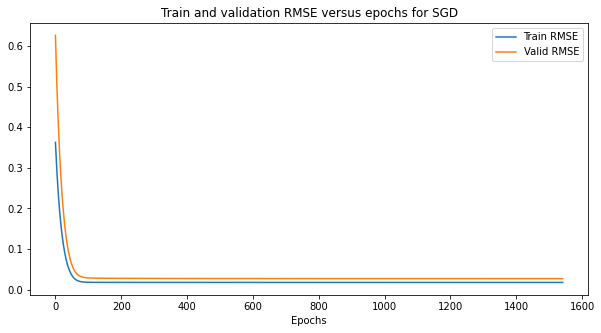

In [1054]:
# SGD training with fixed step size

x_train_2, y_train_2 = xyFromDataset(importDataset("Datasets/Dataset_2_train.csv"))
print(x_train_2.shape)
x_valid_2, y_valid_2 = xyFromDataset(importDataset("Datasets/Dataset_2_valid.csv"))
x_test_2, y_test_2 = xyFromDataset(importDataset("Datasets/Dataset_2_test.csv"))

w0, w1, train_rmse, valid_rmse = performLinearSGD(x_train_2, y_train_2, x_valid_2, y_valid_2, 0.0001)

print(f'w0: {w0:.4f}, w1: {w1:.4f}')
print(f'Last RMSE: {valid_rmse[-1]:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_rmse)), train_rmse, label='Train RMSE')
plt.plot(range(len(valid_rmse)), valid_rmse, label='Valid RMSE')
plt.title('Train and validation RMSE versus epochs for SGD')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [1055]:
# SGD training with different step sizes

for step in [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01,  0.05, 0.1, 0.5]:
    w0, w1, train_rmse, valid_rmse = performLinearSGD(x_train_2, y_train_2, x_valid_2, y_valid_2, step)
    print(f'Step size: {step}, RMSE: {valid_rmse[-1]:.5f}')

Step size: 1e-05, RMSE: 0.02726
Step size: 0.0001, RMSE: 0.02722
Step size: 0.0005, RMSE: 0.02728
Step size: 0.001, RMSE: 0.02729
Step size: 0.005, RMSE: 0.02733
Step size: 0.01, RMSE: 0.02791
Step size: 0.05, RMSE: 0.02752
Step size: 0.1, RMSE: 0.02904
Step size: 0.5, RMSE: 0.05119


In [1056]:
# Evaluation of test performance of best model (0.001 step size)

w0, w1, train_rmse, valid_rmse = performLinearSGD(x_train_2, y_train_2, x_valid_2, y_valid_2, 0.0001)

test_rmse_2 = linearRmse(x_test_2, y_test_2, w0, w1)
print(f'Test RMSE for best SGD model: {test_rmse_2:.4f}')

Test RMSE for best SGD model: 0.0263


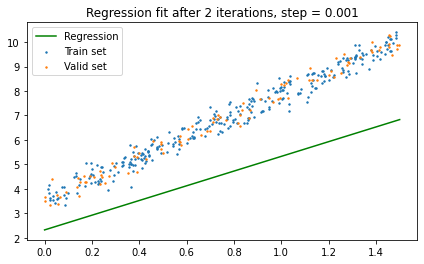

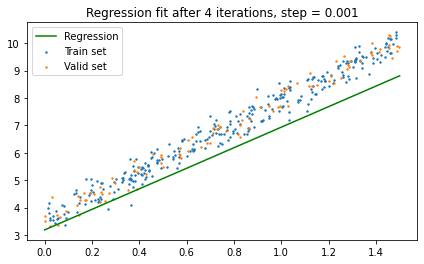

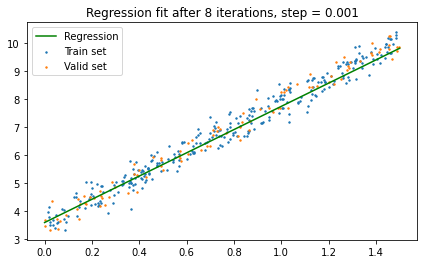

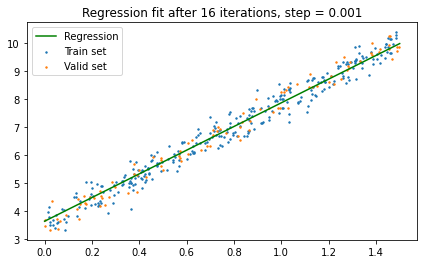

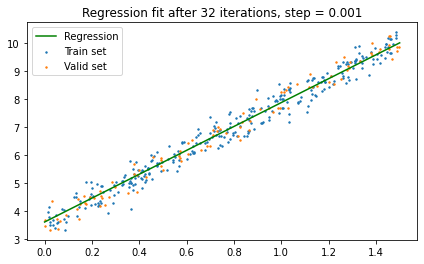

In [1057]:
# Visualizations of regression evolution

for n_iterations in [2, 4, 8, 16, 32]:
    w0, w1, _, _ = performLinearSGD(x_train_2, y_train_2, x_valid_2, y_valid_2, 0.001, max_iter=n_iterations)
    plt.figure(figsize=(7, 4))
    plt.scatter(x_train_2, y_train_2, s=2, label='Train set')
    plt.scatter(x_valid_2, y_valid_2, s=2, label='Valid set')
    plt.plot([0, 1.5], [w0, w0 + 1.5 * w1], label='Regression', color='green')
    plt.title(f'Regression fit after {n_iterations} iterations, step = 0.001')
    plt.legend()
    plt.show()

w0: 3.7695, w1: 4.0947
Last RMSE: 0.0305


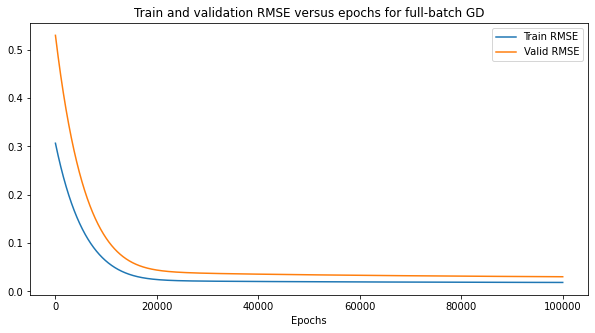

In [1058]:
# Full-batch GD

def performLinearFBGD(x_train, y_train, x_valid, y_valid, step, w0=1, w1=1, max_iter=100000):
    epochs_train_rmse = [linearRmse(x_train, y_train, w0, w1)]
    epochs_valid_rmse = [linearRmse(x_valid, y_valid, w0, w1)]
    n = len(y_train)

    for i in range(max_iter):
        # One epoch of full-batch GD
        w0 = w0 - step  / n * sum([w0 + w1*x - y for (x, y) in zip(x_train, y_train)])
        w1 = w1 - step  / n * sum([x * (w0 + w1*x - y) for (x, y) in zip(x_train, y_train)])

        # Validates RMSE on both sets
        epochs_train_rmse.append(linearRmse(x_train, y_train, w0, w1))
        epochs_valid_rmse.append(linearRmse(x_valid, y_valid, w0, w1))
        
        # Repeats epochs until RMSE begins to increase
        if epochs_train_rmse[-2] < epochs_train_rmse[-1]:
            break

    return w0, w1, epochs_train_rmse, epochs_valid_rmse 

w0, w1, train_rmse, valid_rmse = performLinearFBGD(x_train_2, y_train_2, x_valid_2, y_valid_2, 0.0001)

print(f'w0: {w0:.4f}, w1: {w1:.4f}')
print(f'Last RMSE: {valid_rmse[-1]:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_rmse)), train_rmse, label='Train RMSE')
plt.plot(range(len(valid_rmse)), valid_rmse, label='Valid RMSE')
plt.title('Train and validation RMSE versus epochs for full-batch GD')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## 4. Real life dataset

In [1059]:
# Function for linear regression on multiple variables

def addColumnOfOnes(x, degrees):
    # Transforms x into a matrix with polynomials
    new_x = x
    for degree in range(degrees + 1):
        # Adds new columns of x raised to 'degree' power
        new_x = np.c_[new_x, x**degree]

    # Removes first column as it now contains extra data
    return new_x[:, 1:]

In [1060]:
# Open Communities dataset

with open('Datasets/communities.data') as file:
    dataset_reader = csv.reader(file)
    # Converts to np array and removes non-predictive attributes
    communities_raw = np.asarray(list(dataset_reader))[:, 5:]
    
# Replace ? attributes with -1
communities_raw = np.where(np.core.defchararray.find(communities_raw,'?')!=-1, -1, communities_raw)
communities_raw = communities_raw.astype(float)

In [1083]:
# Replace missing values of dataset

# Finds column means while ignoring -1 values
column_means = np.mean(communities_raw, axis=1, where=(communities_raw >= 0))
# Replaces -1 elements with means of their respective columns
communities_mean = communities_raw.copy()

# Replaces all missing values with means
for rowindex, row in enumerate(communities_raw):
    for colindex, value in enumerate(row):
        if value < 0:
            communities_mean[rowindex, colindex] = column_means[colindex]

# Calculates regression values
regression_storage = communities_raw.copy()
for colindex, column in enumerate(np.transpose(communities_mean)):
    # Removes column so other columns can serve as x
    x = np.delete(communities_mean, colindex, axis=1)
    # Calculates missing column from regression w
    w = calculateW(x, column)
    regression_storage[:, colindex] = np.dot(x, w)

# Replaces missing values with regression predictions
communities_regression = communities_raw.copy()
for rowindex, row in enumerate(communities_raw):
    for colindex, value in enumerate(row):
        if value < 0:
            communities_regression[rowindex, colindex] = regression_storage[rowindex, colindex]

np.savetxt("Datasets/complete_communities.csv", communities_regression, delimiter=',', fmt='%.4f')

In [1073]:
# 20-80 split and k-fold cross validation

def KFoldValidation(train_x, train_y, k, lda=0):
    n = len(train_x)
    rmse_total = 0
    for i in range(k):
        valid_x_i = train_x[round(i * n / k):round((i+1) * n / k)]
        valid_y_i = train_y[round(i * n / k):round((i+1) * n / k)]
        train_x_i = np.delete(train_x, np.s_[round(i * n / k):round((i+1) * n / k)], axis=0)
        train_y_i = np.delete(train_y, np.s_[round(i * n / k):round((i+1) * n / k)], axis=0)

        w = calculateW(train_x_i, train_y_i, lda)
        rmse_total += matrixRmse(valid_x_i, valid_y_i, w)

    return rmse_total / k
        
# Adds 1 for w0 to communities set
N = len(communities_mean)
communities = np.c_[np.ones(N), communities_regression]
# Splits 20/80 test/train
test_x = communities[:round(N/5), :-1]
test_y = communities[:round(N/5), -1]
train_x = communities[round(N/5):, :-1]
train_y = communities[round(N/5):, -1]


w = calculateW(train_x, train_y)
kfold_rmse = KFoldValidation(train_x, train_y, 5)
test_rmse = matrixRmse(test_x, test_y, w)

print(f'5-fold cross-valdation average RMSE: {kfold_rmse:.6f}')
print(f'Test RMSE: {test_rmse:.6f}')

5-fold cross-valdation average RMSE: 0.007797
Test RMSE: 0.006888


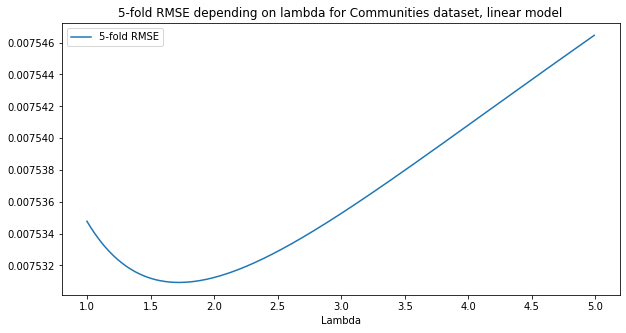

In [1079]:
# Ridge regression

lambdas = np.arange(1, 5, 0.01)
best_lambda = None
kfold_rmses = []
for lda in lambdas:
    kfold_rmse = KFoldValidation(train_x, train_y, 5, lda)
    kfold_rmses.append(kfold_rmse)
    if kfold_rmse == min(kfold_rmses):
        best_lambda = lda

plt.figure(figsize=(10, 5))
plt.plot(lambdas, kfold_rmses, label='5-fold RMSE')
plt.title('5-fold RMSE depending on lambda for Communities dataset, linear model')
plt.xlabel('Lambda')
plt.legend()
plt.show()

In [1077]:
# Evaluating the best model on the test set

print(f'Best lambda 5-fold: {best_lambda:.2f}')

best_model = calculateW(train_x, train_y, best_lambda)
test_rmse = matrixRmse(test_x, test_y, best_model)
print(f'Best model RMSE on test set: {test_rmse:.6f}')

Best lambda 5-fold: 1.72
Best model RMSE on test set: 0.006994


In [1080]:
# Feature selection

# Reduces features to 25% most relevant
feature_weight_threshold = np.percentile(abs(best_model), 75)
columns_to_delete = [index for (index, value) in enumerate(best_model) if abs(value) < feature_weight_threshold]
communities_reduced = np.delete(communities, columns_to_delete, axis=1)

# Splits reduced dataset into same 20/80 test/train
test_x_reduced = communities_reduced[:round(N/5), :-1]
test_y_reduced = communities_reduced[:round(N/5), -1]
train_x_reduced = communities_reduced[round(N/5):, :-1]
train_y_reduced = communities_reduced[round(N/5):, -1]

# Calculates new lambda for reduced set
lambdas = np.arange(1, 5, 0.01)
best_lambda_reduced = None
kfold_rmses = []
for lda in lambdas:
    kfold_rmse = KFoldValidation(train_x_reduced, train_y_reduced, 5, lda)
    kfold_rmses.append(kfold_rmse)
    if kfold_rmse == min(kfold_rmses):
        best_lambda_reduced = lda

# Calculates test set RMSE with reduced model
best_model_reduced = calculateW(train_x_reduced, train_y_reduced, best_lambda_reduced)
test_rmse = matrixRmse(test_x_reduced, test_y_reduced, best_model_reduced)
print(f'Best reduced model RMSE on test set: {test_rmse:.6f}')

Best reduced model RMSE on test set: 0.006999
